&nbsp;
&nbsp;
&nbsp;    
    
#  Prediction of diabetes incidence using serum microRNAs 
by *Alexandros Karagiannopoulos*

&nbsp; 

The published dataset of [Gallo et. al, 2018](https://pubmed.ncbi.nlm.nih.gov/30408096/) was used in this project and selected as I may work on a similar dataset in the future.

The dataset includes a table with the __expression level of 47 microRNAs (miRNAs)__ in fasting serum for 560 healthy subjects, of whom __140 developed diabetes__, and 169 cardiovascular diseases during follow-up.

The aim of this project is to apply machine learning (ML) methods that would allow us to predict if a healthy patient will develop diabetes in the future given the expression of those 47 miRNAs. 
 
First we will import the table and some necessary python packages:

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print('All packages are in place!')
#Read in the data to a pandas DataFrame using the read_csv method.

data = pd.read_excel('Normalized_relative_quantities.xlsx')

print('Dataset is loaded!')

All packages are in place!
Dataset is loaded!


Let's check the table:

In [2]:
data

,CardID,inc_dm_2009,inc_cv_2009,hsa-miR-1274A-002883,hsa-miR-17-002308,hsa-miR-1243-002854,hsa-miR-1274B-002884,hsa-miR-625*-002432,hsa-miR-223-002295,hsa-miR-126-002228,...,hsa-miR-21-000397,hsa-miR-30b-000602,hsa-miR-26a-000405,hsa-miR-142-3p-000464,hsa-miR-331-000545,hsa-miR-25-000403,hsa-miR-335-000546,hsa-miR-374-000563,hsa-miR-139-5p-002289,hsa-miR-720-002895
0,1-A1,0.0,0.0,1.440929,0.610050,NaN,1.340712,0.983501,0.005979,1.629015,...,0.731535,4.307949,2.873880,0.127981,NaN,NaN,1.557248,NaN,1.537940,2.350554
1,1-B1,0.0,1.0,2.459730,0.947041,NaN,3.449772,NaN,0.014097,0.901563,...,1.089375,0.418559,NaN,0.238904,NaN,NaN,2.734922,NaN,3.697375,5.181971
2,1-C1,0.0,0.0,0.781598,0.783225,NaN,0.393791,0.735858,0.002369,0.751842,...,0.607729,1.372210,2.518388,0.388369,NaN,0.000005,0.784312,NaN,0.707842,0.837116
3,1-D1,0.0,0.0,0.905634,0.803293,NaN,0.381565,1.816296,0.001835,0.958600,...,1.175277,1.548640,1.769080,0.309498,0.436181,NaN,NaN,NaN,0.632001,1.397648
4,1-E1,0.0,0.0,1.552398,0.779434,NaN,0.419139,0.233016,0.001608,0.931417,...,0.594810,2.056941,2.609004,1.241858,0.629597,NaN,0.336459,NaN,0.539427,1.589418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,6-D10,0.0,0.0,5.241568,0.970634,1.063999e-07,3.660398,2.385016,0.001686,0.643049,...,0.803293,2.418310,1.075493,0.658840,0.910669,NaN,1.640346,1.115739,0.313383,2.193144
556,6-E10,0.0,0.0,5.909351,0.948684,5.662446e-08,3.474971,0.931740,0.000647,1.356603,...,1.368883,1.019598,2.106720,0.249654,NaN,NaN,0.631126,NaN,1.404445,3.292081
557,6-F10,0.0,1.0,2.000000,0.903126,9.595959e-08,2.543826,0.980779,0.000910,1.247466,...,1.123499,2.674002,2.675855,0.241317,2.579338,NaN,1.760520,0.590497,1.737483,1.508381
558,6-G10,0.0,0.0,1.048990,1.088996,6.865452e-09,1.790050,0.513345,0.001711,0.690637,...,0.721965,2.008336,1.930533,0.329648,NaN,NaN,2.047697,NaN,1.059218,0.893166


## Data Description and Processing

* Column 1 (*CardID*): The subject's ID
* Column 2 (*inc_dm_2009*): The subject developed (1) or not (2) diabetes
* Column 3 (*inc_cv_2009*): The subject developed (1) or not (2) cardiovascular disease
* Column 4-50: miRNA expression levels generated by microarrays 

In this project we will choose to predict __only the diabetes__ incidence, so *Column 3* will not be used.

Having a first look at the table, we can see there are quite many missing values. Gene expression data generated from microarrays tend to result in such missing values, but we will deal with it later.

First, let's check if there any missing values for our target variable "inc_dm_2009":

In [3]:
data['inc_dm_2009'].isna().sum()

7

We are going to remove these 7 subjects.  
Also we are going to remove the "subject ID labels" and "prediction for cardiovascular disease" columns since they are not necessary:

In [4]:
data_clean = data.drop(['CardID','inc_cv_2009'], 1)

data_clean = data_clean.dropna(how='any', subset=['inc_dm_2009'])

data_clean.shape

(553, 48)

Another thing we should pay attention to is how *__balanced__* the predicting target variable of our dataset is, in other words, how many subjects develop diabetes (__1__) vs how many they don't (__0__) during follow-up:

Proportion: 2.57 : 1


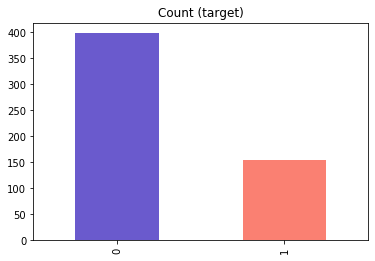

In [6]:
y = data_clean['inc_dm_2009'].astype(int)
y_counts = y.value_counts()

y_counts.plot(kind='bar', title='Count (target)', color=['slateblue','salmon']);

print('Proportion:', round(y_counts[0] / y_counts[1], 2), ': 1')

We can see a big disproportion, which can cause the ML algorithms to identify easier the 0s than the 1s. Indeed the ML methods used in this project were first trained with the original unbalanced data and, unsurprisingly, they could only predict 0s. This can be handled by:
* __Downsampling the majority class__, or
* __Upsampling the minority class__ (by random resampling with replacement)

In both cases there are drawbacks. In the first case, we eliminate potentially crucial training input into our ML algorithms, while in the second one, since some elements are repeated there is the danger that same elements end up in both the training and testing set and the algorithms are overfitted.

After trying both approaches, upsampling the minority class gave significantly better results as downsampling will further limit our already limited number of samples. It is possible to have some degree of overfitting at our models, but the fact that their hyperparameters were tuned based on cross-validation (see below) and the existence of regularization parameters in the ML methods will reduce its size.  

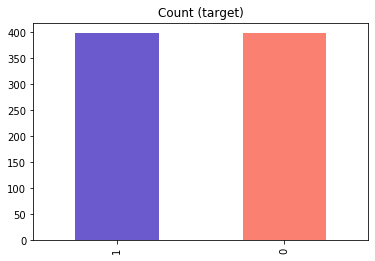

In [7]:
#Up-sample Minority Class

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data_clean[data_clean['inc_dm_2009']==0]
df_minority = data_clean[data_clean['inc_dm_2009']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=398,    # to match majority class
                                 random_state=123) 


# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

#Our feature varuables (miRNA values) start from the 3rd column
X = df_upsampled.iloc[:,3:]
y = df_upsampled['inc_dm_2009'].astype(int)

# Display new class counts
y_counts = y.value_counts()

y_counts.plot(kind='bar', title='Count (target)', color=['slateblue','salmon']);

Before we process the feature variables, we should split the data into our training and test set. This is to ensure *no information from the test set will "leak" into our training data*. The *stratify* arguement ensures that the distribution of the target variable in the training and test will be equal to that of the original set.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Now let's go on to process the miRNA expression values. First let's check the distribution of the first column:

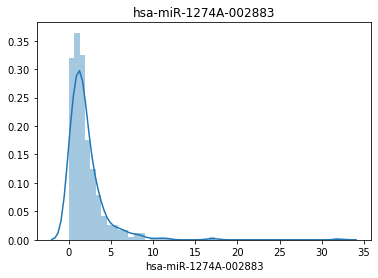

In [13]:
#Let's plot two random columns to see the distribution
plt.clf()
sns.distplot(data_clean['hsa-miR-1274A-002883'])
plt.title('hsa-miR-1274A-002883')
plt.show()



As expected with the gene expression data, our miRNA expression values follow a *__negative binomial distribution__* which is skewed towards 0. This is because the majority of the expression values are expected to be equal or close to 0.   

However, many ML methods assume data are normally distributed and normalized/scaled (e.g. support vector machine(svm), k-nearest neighbors (knn),...). So at the same time, we will handle the issue of missing values with imputation as some ML methods cannot process missing values. According to [Troyanskaya et. al, 2001](https://academic.oup.com/bioinformatics/article/17/6/520/272365) and [Scheel et. al, 2005](https://pubmed.ncbi.nlm.nih.gov/16216830/) a widely used method to do this is by knn-imputation after removing columns with more than 10% missing information. 

So the data processing (seperately for the training and test sets) includes:
1. __Log-transformion__: data will follow the normal distribution 
2. __Imputation__ on columns with < 10% missing information - the rest will be dropped 
3. __Data scaling__ 


In [6]:
#Log-transformion

X_train_log = np.log2(X_train)
X_test_log = np.log2(X_test)

#Imputation

#remove columns with missing data > 10% in the whole dataset and then impute test and train sets
cols = X.columns[X.isnull().mean() < 0.1]

X_train_log_flt = X_train_log[cols]
X_test_log_flt = X_test_log[cols]

#13/49 columns (feature variables) were removed

#knn-imputation - fit and transform the train set and then fit to the test set in order to simulate real testing conditions
from sklearn.impute import KNNImputer
    
imputer = KNNImputer(n_neighbors=5, weights="uniform")

X_train_imp = imputer.fit_transform(X_train_log_flt)
X_test_imp = imputer.transform(X_test_log_flt) 

#Now we will scale the data to [0,1] as it is necessary for some distance-based machine learning estimators (SVM, knn) 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc = scaler.transform(X_test_imp) #Here we only need to transform the test data

print('Processing done')

Processing done


## Performance measures

As mentioned earlier, originally the target variable of the dataset was highly imbalanced (many 0s = subject will remain healthy and few 1s = subject will develop diabetes).

When I first trained and cross-validated the dataset I was getting relatively good __precision__ scores (e.g. 0.75), although my models could <u>only predict the 0s</u>, meaning that by definition precision for class 0 was 100 and for class 1 was 0. Howerver, as 0s were 2.5 times more in the test set the average was 0.75. 

So in order to account for both the false positives and the false negatives and the differences between the 2 classes, the __average f1 score__ between the classes was selected as the most appropriate performance measure. 

It should be mentioned that __AUC__ is not ideal for imbalanced data and it is less interpretable as the increasing of AUC doesn't really reflect a better classifier (e.g. a score can be high due to large *false positives*, rather than the large *true positives*)


## Grid Search and Cross-Validation

Every ML method's performance is determined by a number of hyperparapmeter values (external characteristics of the model that cannot be estimated from the data) defined by the user. A grid search is the process where hyperparameter tuning is performed in search of the best combination of hyperparameter values that results in the most "accurate" predicitons.  

This hyperparameter optimization is performed using stratified k-fold cross-validation (default in the sklearn's grid search algorithm) where: 
1. the training data is first split into k subsets (k-fold) with the same percentage of samples for each class (stratified)
2. the model is trained on all but one (k-1) of the subsets
3. the performance of the model is evaluated on the subset that was not used for training

This ensures that training and validation is not performed in the same samples and __prevents the model from overfitting__. 

*10-fold* cross-validation was selected for validation in our models.  



## Machine Learning methods

After we processed our data, it is time to start training and evaluating ML methods. 

### Support Vector Machine (SVC)

First we will start with a Support Vector Machine (SVC). The aim of the algorithm is to find a hyperplane in a N-dimensional space (N = number of features) that seperates the data points of two classes. A hyperplane is a decision boundary where the distance between data points of both classes (functional margin) is maximized and in that way the data points can be classified. 


Here we will perform a grid search searching for the best values of the hyperparameters:  
* __kernel__: When two classes can't be seperated by a line, they can be transformed in a non-linear manner and a hyperplane can be searched in the transformed data points. These transformation functions are are called kernels.
* __regularization parameter C__: determines how many data samples are allowed to be placed in different classes
* __gamma__: determines the curvature of the decision boundary or, simply put, the distance a single data sample exerts influence

Finally we will use the best best hyperparameter values to evaluate the model in our test data:

Best Kernel: rbf
Best C: 1
Best gamma: 100
Best Score: 0.91

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        80
           1       1.00      0.90      0.95        80

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.95      0.95      0.95       160



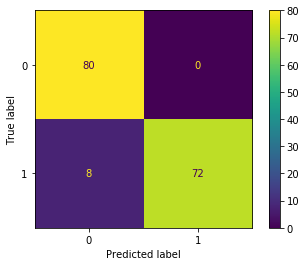

--- 22.28 seconds ---


In [15]:
#SVM model

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time

start_time = time.time()

#parameters for grid search
parameters = [{'kernel':['linear'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000]}, 
              {'kernel':['rbf'],'C':[0.001,0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001,0.01, 0.1, 1, 10, 100, 1000]}]

#define the model
svc = svm.SVC(random_state = 42)

#grid search in our training data
svm_model = GridSearchCV(svc, parameters, cv = 10, scoring = 'f1_macro')
svm_model = svm_model.fit(X_train_sc, y_train) 
   
print('Best Kernel:', svm_model.best_estimator_.get_params()['kernel'])
print('Best C:', svm_model.best_estimator_.get_params()['C'])
print('Best gamma:', svm_model.best_estimator_.get_params()['gamma'])
print("Best Score: %0.2f" % svm_model.best_score_)
print()

#predict in our test data
y_true, y_pred = y_test, svm_model.predict(X_test_sc)

#print table and graph
print("Classification Report:", "\n", classification_report(y_true, y_pred))

plot_confusion_matrix(svm_model, X_test_sc, y_test)
plt.show()

print("--- %0.2f seconds ---" % (time.time() - start_time))

The best combination of hyperparameters shown in the first 4 lines give an *average f1 score* of 0.91 using the cross-validated training data. When hyperparameters are applied in the test data they give an average f1 score of 0.95.

According tot the confusion matrix, only 8 out of 80 samples of class 1 were false negatives, while the rest of the samples were classified correctly. 



### Decision Trees and Dimensionality Reduction

Decision Trees use an algorithmic approach to identify parameters in the data set that will let them split the data in a sequential and hierarchical way across branches, such that can lead to the classification of the data. 

Although they are very easy to interpret and are pretty accurate for small datasets, the lack of extensive hyperparameters make them prone to overfitting. This is why it is suggested to performe dimensionality reduction beforehand to give our tree a better chance of finding features that are discriminative.

Here we will select the __Principal Compponent Analysis (PCA)__ as our dimensionality reduction technique in order to decompose our 36 feature variables in a set of components that explain a maximum amount of variance in the data set. The output of PCA will be the input of the Decision Tree estimator.

*Sklearn* allows us to decide the best number of PCA components to be included in our model by incorporating that to the Grid Search. In the Grid Search we will also search for the best values of the hyperparameters:
* __criterion__: The function to measure the quality of a split
* __max_depth__: The maximum number of levels in the tree


Finally we will use the best best hyperparameter values to evaluate the model in our test data:

Best Criterion: entropy
Best max_depth: 24
Best Number Of Components: 17
Best Score: 0.82

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.68      0.78        80
           1       0.74      0.94      0.83        80

    accuracy                           0.81       160
   macro avg       0.83      0.81      0.80       160
weighted avg       0.83      0.81      0.80       160



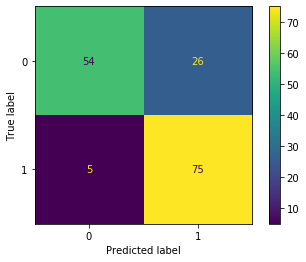

--- 67.08 seconds ---


In [18]:
#Decision Trees


#We take advantage of the Pipeline function of sklearn in order to grid search for the best number of PCA 
#components to input in our decision trees, and the best hyperparameters of our tree at the same time 

from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time

start_time = time.time()

pca = decomposition.PCA()
decisiontree = DecisionTreeClassifier(random_state = 45)

# Create a pipeline of two steps: 

# 1) tranform the data with PCA, 2) train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca), ('decisiontree', decisiontree)])

# 2) Create Parameter Space

# Create a list of a sequence of integers to integrate from PCA
n_components = list(range(1,X_train_sc.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = list(range(4,30,4))
parameters = dict(pca__n_components=n_components,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)


model_dt = GridSearchCV(pipe, parameters, cv = 10, scoring = 'f1_macro')
model_dt.fit(X_train_sc, y_train)

print('Best Criterion:', model_dt.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', model_dt.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', model_dt.best_estimator_.get_params()['pca__n_components'])
print("Best Score: %0.2f" % model_dt.best_score_)
print()

#predict in our test data
y_true, y_pred = y_test, model_dt.predict(X_test_sc)

print("Classification Report:", "\n", classification_report(y_true, y_pred))

#Confusion plot    
plot_confusion_matrix(model_dt, X_test_sc, y_test)
plt.show()

print("--- %0.2f seconds ---" % (time.time() - start_time))

The best combination of hyperparameters shown in the first 3 lines give an *average f1 score* of 0.82 using the cross-validated training data. When hyperparameters are applied in the test data they give an average f1 score of 0.80.

According tot the confusion matrix, the model is better at predicting 1s than 0s (more false positives than false negatives). 

### k-nearest neighbors (KNN)

The KNN model assumes that similar things exist in close proximity. So after storing the entire training dataset, when a prediction is required, the k-most similar records to a new record (neighbors) from the training dataset are located. From these neighbors, a summarized prediction is made. This model is used mainly for classification and it is easy to interpret.

Here we will perform a Grid Search for the values of the hyperparameters:  
* __n_neighbors__: Number of neighbors to be used for the prediction
* __weights__: Weight function used in predictions
* __leaf_size__: Different algorithms are used to compute the nearest neighbors. Due to high computational time, some algorithms opt for a tree-based query instead of brute force search. *leaf_size* determines the point at which the tree-based query will internally switch to a brute force searching.

Finally we will use the best best hyperparameter values to evaluate the model in our test data:

Best leaf_size: 1
Best weight function: uniform
Best n_neighbors: 1
Best Score: 0.77
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.75      0.82        80
           1       0.79      0.93      0.85        80

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160



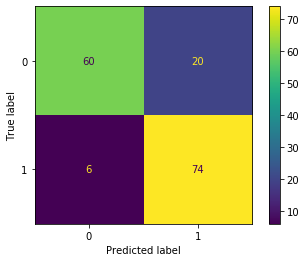

--- 11.60 seconds ---


In [20]:
#Knn 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time

start_time = time.time()

#define the model and grid parameters
knn = KNeighborsClassifier()

parameters = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19,21], #usually odd numbers
              'leaf_size':[1,2,3,5],
              'weights':['uniform', 'distance']}

#Fit the model
model_knn = GridSearchCV(knn, param_grid=parameters, cv = 10, scoring = 'f1_macro')
model_knn.fit(X_train_sc,y_train)

print('Best leaf_size:', model_knn.best_estimator_.get_params()['leaf_size'])
print('Best weight function:', model_knn.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', model_knn.best_estimator_.get_params()['n_neighbors'])
print("Best Score: %0.2f" %  model_knn.best_score_)

#predict in our test data
y_true, y_pred = y_test, model_knn.predict(X_test_sc)

print("Classification Report:", "\n", classification_report(y_true, y_pred))

#Confusion plot    
plot_confusion_matrix(model_knn, X_test_sc, y_test)
plt.show()  

print("--- %0.2f seconds ---" % (time.time() - start_time))

The best combination of hyperparameters shown in the first 3 lines give an *average f1 score* of 0.77 using the cross-validated training data. When hyperparameters are applied in the test data they give an average f1 score of 0.84.

According tot the confusion matrix, the model is better at predicting 1s than 0s (more false positives than false negatives).

### Random Forest and Randomized Hyperparameter Search

A Random Forest Classifier consists of a large number of individual decision trees, each one created from a subset of the training set. Then it aggregates the results in order to decide the best classification parameters.

It is a widely used algorithm due to its structure, however the performance depends on a large number of hyperparameters. That is why we will use a different approach to do the hyperparameter tuning, the __RandomizedSearchCV__. Contrary to a Grid Search, not all parameter values will be tried out, but rather random combinations of them. The number of combinations is defined by __n_iter__. 

We choose this approach as the large number of hyperparameters will make an exhaustive Grid Search computationally expensive. 

The Randomized Search will be used to tune the hyperparameters:  
* __n_estimators__: Number of trees in the random forest
* __max_features__: Number of features to consider at every split
* __max_depth__: Maximum number of levels in tree
* __min_samples_split__: Minimum number of samples required to split a node
* __min_samples_leaf__: Minimum number of samples required to be at each leaf node
* __bootstrap__: Method of selecting samples for training each tree. If False, the whole dataset is used to build each tree.

Finally we will use the best best hyperparameter values to evaluate the model in our test data:

Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Best Score: 0.89
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        80
           1       1.00      0.90      0.95        80

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.95      0.95      0.95       160



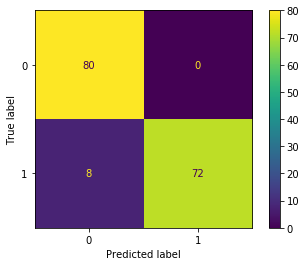

--- 624.08 seconds ---


In [21]:
#Random Forests


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time

start_time = time.time()

#define the model and hyperparameters
rf = RandomForestClassifier()

n_estimators = [200, 500, 1000, 1500, 2500]
max_features = ['auto', 'log2']
max_depth = [10, 20, 30, 40, 50]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#fit the model
rf_random = RandomizedSearchCV(
    estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, 
    scoring = 'f1_macro', n_jobs = -1, random_state = 42)
rf_random.fit(X_train_sc, y_train)

print("Best Parameters:", rf_random.best_params_)
print("Best Score: %0.2f" % rf_random.best_score_)

#predict in our test data
y_true, y_pred = y_test, rf_random.predict(X_test_sc)

print("Classification Report:", "\n", classification_report(y_true, y_pred))

#Confusion plot    
plot_confusion_matrix(rf_random, X_test_sc, y_test)
plt.show() 

print("--- %0.2f seconds ---" % (time.time() - start_time))

The best combination of hyperparameters shown in the first line give an *average f1 score* of 0.89 using the cross-validated training data. When hyperparameters are applied in the test data they give an average f1 score of 0.95.

According tot the confusion matrix, only 8 out of 80 samples of class 1 were false negatives, while the rest of the samples were classified correctly.

### Random Forest Important Features

This model lets us extract the feature coefficients and have a look at the miRNAs the classification process was based on. This can be useful in order to identify future miRNA targets that could predict if an individual will develop diabetes in the future:  

In [29]:
# define the model
rfr_model = rf_random.best_estimator_

# fit the model
rfr = rfr_model.fit(X_test_sc, y_test)
# get coefficients
importance_rfr = rfr.feature_importances_

   
#summarize feature importance - correspond it with the feature names of our dataset
feature_dict_rfr = {}
for i,v in enumerate(importance_rfr):
    if v != 0:
        feature_dict_rfr[cols[i]] = v
#print only no negative coefficients
for w in sorted(feature_dict_rfr, key=feature_dict_rfr.get, reverse=True):
    print("Feature: {} - Coef: {:.3}".format(w, feature_dict_rfr[w])) 
       

Feature: hsa-let-7e-002406 - Coef: 0.0608
Feature: hsa-miR-142-3p-000464 - Coef: 0.0504
Feature: hsa-miR-186-002285 - Coef: 0.0484
Feature: hsa-miR-484-001821 - Coef: 0.0482
Feature: hsa-miR-223-002295 - Coef: 0.0389
Feature: hsa-miR-150-000473 - Coef: 0.0349
Feature: hsa-miR-191-002299 - Coef: 0.0338
Feature: hsa-miR-20b-001014 - Coef: 0.0338
Feature: hsa-miR-26a-000405 - Coef: 0.0338
Feature: hsa-miR-24-000402 - Coef: 0.0299
Feature: hsa-miR-126-002228 - Coef: 0.0295
Feature: hsa-miR-574-3p-002349 - Coef: 0.029
Feature: hsa-miR-92a-000431 - Coef: 0.0282
Feature: hsa-miR-30b-000602 - Coef: 0.0278
Feature: hsa-let-7b-002619 - Coef: 0.0275
Feature: hsa-miR-342-3p-002260 - Coef: 0.0269
Feature: hsa-miR-16-000391 - Coef: 0.0268
Feature: hsa-miR-106a-002169 - Coef: 0.0266
Feature: hsa-miR-146a-000468 - Coef: 0.0264
Feature: hsa-miR-320-002277 - Coef: 0.0257
Feature: hsa-miR-483-5p-002338 - Coef: 0.0257
Feature: hsa-miR-222-002276 - Coef: 0.0247
Feature: hsa-miR-1274B-002884 - Coef: 0.0245


### Logistic Regression

We will perform a logistic regression in order to identify the relationship between our target binary variable and the feature variables and be able to classify the samples. To avoid overfitting, we apply regularization by penalizing high-valued regression coefficients. In this way, the model is shrinked (simplified) and more generalized. 

We will perform a Grid Search for the best values of the hyperparameters:  
* __penalty__: Determines the type of penalization during regularization
* __solver__: The optimization method to find the optimum of the objective function

Finally we will use the best best hyperparameter values to evaluate the model in our test data:

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.60
Classification Report: 
               precision    recall  f1-score   support

           0       0.59      0.62      0.61        80
           1       0.60      0.56      0.58        80

    accuracy                           0.59       160
   macro avg       0.59      0.59      0.59       160
weighted avg       0.59      0.59      0.59       160



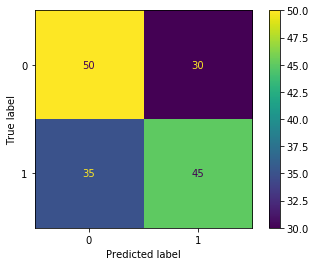

--- 4.14 seconds ---


In [25]:
#Logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time

start_time = time.time()

# Create logistic regression
logistic = LogisticRegression(random_state = 42) #This optimazation algorithm is the only one compatible with all 3 penalties

# Create regularization penalty space
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1','l2', 'elasticnet', 'none']

# Create regularization hyperparameter space
C = [0.001,0.01, 0.1, 1, 10, 100, 1000]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# Create grid search using 5-fold cross validation
model_log = GridSearchCV(logistic, hyperparameters, cv=10, scoring = 'f1_macro', n_jobs = -1)
model_log.fit(X_train_sc,y_train)

print("Best Parameters:", model_log.best_params_)
print("Best Score: %0.2f" % model_log.best_score_)

#predict in our test data
y_true, y_pred = y_test, model_log.predict(X_test_sc)

print("Classification Report:", "\n", classification_report(y_true, y_pred))

#Confusion plot    
plot_confusion_matrix(model_log, X_test_sc, y_test)
plt.show()

print("--- %0.2f seconds ---" % (time.time() - start_time))

The best combination of hyperparameters shown in the first line give an *average f1 score* of 0.60 using the cross-validated training data. When hyperparameters are applied in the test data they give an average f1 score of 0.59.

According tot the confusion matrix, there are many equally many false positives and false negatives.

### Logistic regression Important Features

This model also lets us extract the feature coefficients and see in which miRNAs the classification process was based on: 

In [26]:
# define the model
logm = model_log.best_estimator_

# fit the model
log = logm.fit(X_test_sc, y_test)

# get feature coefficients
importance_log = log.coef_[0]

# summarize feature importance - correspond it with the feature names of our dataset
feature_dict_log = {}
for i,v in enumerate(importance_log):
    if v != 0:
        feature_dict_log[cols[i]] = v
#print only no negative coefficients
for w in sorted(feature_dict_log, key=feature_dict_log.get, reverse=True):
    print("Feature: {} - Coef: {:.3}".format(w, feature_dict_log[w]))

Feature: hsa-miR-150-000473 - Coef: 0.34
Feature: hsa-miR-142-3p-000464 - Coef: 0.132
Feature: hsa-let-7e-002406 - Coef: 0.0694
Feature: hsa-miR-574-3p-002349 - Coef: -0.189
Feature: hsa-miR-484-001821 - Coef: -0.539


### Ensemble methods

Ensemble methods combine multiple ML algorithms to increase their predictive performance compared to that of any of the constituent learning algorithm alone. We will use two approaches:

* __Majotity Voting Classifier__: 
Every model makes a prediction (vote) for each test instance and the final output prediction is the one that receives more than half of the votes (__Voting=hard__ should be set)

* __Stacking Classifier__: 
The predictions of every model are combined (stacked) and used by another classifier (__final estimator__) which will predict the final output. As our final estimator the default (__Logistic Regression__) was selected.


All four models (__svm__, __knn__, __random forest__, __logistic regression__) are going to be used with the two Ensemble methods supplied with the hyperparameters that performed best given our training data. The __decision tree classifier__, which was trained on PCA-transformed training data, will not be used.

Ensembl Score: 0.95
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        80
           1       1.00      0.90      0.95        80

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.95      0.95      0.95       160



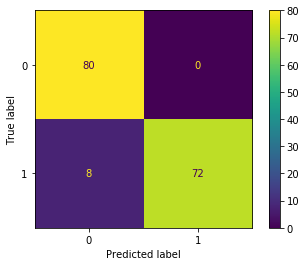

--- 2.92 seconds ---


In [27]:
#Ensemble - Voting Classifier


from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time

start_time = time.time()

#Define the models with the best hyperparameters  
rf_best = rf_random.best_estimator_
knn_best = model_knn.best_estimator_
log_best = model_log.best_estimator_
svm_best = svm_model.best_estimator_

#create a dictionary of our models
estimators=[('knn', knn_best), ('rf', rf_best), ('log', log_best),('svm', svm_best)]

#create our voting classifier, inputting our models
ensemble_vt = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble_vt.fit(X_train_sc, y_train)

#test our model on the test data
print("Score: {:.2}".format(ensemble_vt.score(X_test_sc, y_test)))

y_true, y_pred = y_test, ensemble_vt.predict(X_test_sc)

print("Classification Report:", "\n", classification_report(y_true, y_pred))

#Confusion plot    
plot_confusion_matrix(ensemble_vt, X_test_sc, y_test)
plt.show()

print("--- %0.2f seconds ---" % (time.time() - start_time))

Ensembl Score: 0.95
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        80
           1       1.00      0.90      0.95        80

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.95      0.95      0.95       160



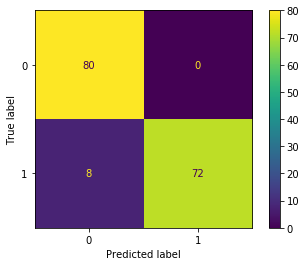

--- 25.94 seconds ---


In [28]:
#Ensemble - Stacking Classifier

#the predictions of each individual base learner are stacked together and used as input to a 
#meta learner to compute the prediction. This meta learner is then trained through cross-validation.

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time

start_time = time.time()

#Define the models with the best hyperparameters  
rf_best = rf_random.best_estimator_
knn_best = model_knn.best_estimator_
log_best = model_log.best_estimator_
svm_best = svm_model.best_estimator_

#create a dictionary of our models
estimators=[('knn', knn_best), ('rf', rf_best), ('log', log_best), ('svm', svm_best)]

#create our voting classifier, inputting our models
ensemble_st = StackingClassifier(estimators=estimators, cv = 10, 
                                 final_estimator = LogisticRegression())


#fit model to training data
ensemble_st.fit(X_train_sc, y_train)    
    
#test our model on the test data
print("Ensembl Score:", ensemble_st.score(X_test_sc, y_test))

y_true, y_pred = y_test, ensemble_st.predict(X_test_sc)

print("Classification Report:", "\n", classification_report(y_true, y_pred))

#Confusion plot    
plot_confusion_matrix(ensemble_vt, X_test_sc, y_test)
plt.show()

print("--- %0.2f seconds ---" % (time.time() - start_time))

## Method comparison 

### Ease-of-use: 
I found the __Decision Trees__, __KNN__ and __Logistic Regression__ algorithms  to be the easiest to use, as the number of "necessary" hyperparameters to adjust was low. They are also more interpretable compared to the other algorithms. Although they are very quick and simple, they had the worst performance (0.80, 0,84, 0.59 on the test set, respectively).  

### Performance:
__SVM__ and __Random Forest__ had the highest performance on the test data (0.95), while __SVM__ had a slightly better performance on the cross-validation of the training data (0.91 vs 0.89). Suprisingly, although they had identical performance on the test set, __SVM__ was significantly faster (22s vs 624s). 
Both __Ensemble__ methods reached, but could not improve, the performance of these algorithms generating the same score (0.95). 

### Computational Time: 
As expected, algorithms with lower number of hyperparameters to be tuned required less computational time to be trained and cross-validated. __KNN__ and __Logistic Regression__ were the faster methods, but as mentioned before, they performed poorly.

### Important Feaure Variables:
Two of the ML methods, __Logistic Regression__ and __Random Forest__ could provide us with the coefficients of the features. As seen from the corresponding tables, __Random Forest__ used almost all (34/36) features when predicting the outcome, while __Logistic Regression__ used only 5. This is because of its stricter L1 penalty during the regularization process.

In the original study, 2 miRNAs were correlated with the future diabetes incidence using logistic regression adjusted for *sex* and *age*. One of the 2, *hsa-let-7e-002406*, was also among the 5 "important" featues in our __Logistic Regression__ model. The other one was not identified, meaning that sex and age, if they were publicly available, would be useful incorporate to our dataset in order to achieve more accurate predictions.
